<a href="https://colab.research.google.com/github/theolouvet/DatasetTest/blob/master/Vggdptest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose
import tarfile

import pandas as pd
from zipfile import ZipFile
import io
import cv2 
import os
import sys
from google.colab import files
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *

from PIL import Image, ImageOps
from io import BytesIO

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [ ]:
def count_parameters(model):
    #for parameter in model.parameters():
    #    print(parameter)
    #print ('nb of trainable parameters')
    return (sum([p.numel() for p in model.parameters() if p.requires_grad]))

In [ ]:
class Subset(torch.utils.data.Dataset):
      def __init__(self, dataset, indices):
          self.dataset = dataset
          self.indices = indices
      def __getitem__(self, idx):
          return self.dataset[self.indices[idx]]
      def __len__(self):
          return len(self.indices)

In [ ]:
def padding(img,expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width //2
    pad_height = delta_height //2
    padding = (pad_width,pad_height,delta_width-pad_width,delta_height-pad_height)
    return ImageOps.expand(img, padding)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, txt_path='/content/Output_seuillage/small_training_dataset.csv'
, img_dir='/content/Output_seuillage/', transform=None, test=False):
     # initialize variables such is path to csv file and images and transforms
    df = pd.read_csv(txt_path)
   
    #self.categories = categories
    self.img_names = df.ID.values
    self.format_img = '.jpg'
    self.species = df.species.values
    self.txt_path = txt_path
    self.img_dir = img_dir
    self.transform = transform
    self.to_tensor = ToTensor()
    self.to_pil = ToPILImage()

    self.get_image_selector = True if img_dir.__contains__('tar') else False
    self.tf = tarfile.open(self.img_dir) if self.get_image_selector else None
    self.transform_gt = transform if test else Compose(self.transform.transforms[:-1])  # omit noise of ground truth
    
    print("dataset initialise")
  def set_categories(self, cat):
    self.categories = cat
  def __len__(self):
      # here you just need to return a single integer number as the length of your dataset, in your 
      #  case, number of images in your train folder or lines in csv file
    return len(self.img_names)
      #return 1;
  def get_image_from_folder(self, name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: a PIL image
        """
        image_name = os.path.join(self.img_dir, str(name))
        image_name =image_name + str(self.format_img)
        image = Image.open(image_name)
        #image = plt.imread(image_name)
        #print(image.size())
        newsize = 256 
        resize = (224, 224)
        image = padding(image, newsize)
        image = image.resize(resize) 
        trans1 = transforms.ToTensor()
      
        return trans1(image)
  def getTarget(self, index):
    return self.categories.get(self.species[index])
  def getNameSpecies(self, idDictionary):
    return list(test.keys())[list(test.values()).index(idDictionary)]
  def show(self, index):
    trans = transforms.ToPILImage()
    img = self.get_image_from_folder(self.img_names[index])
    plt.imshow(trans(img))
  def __getitem__(self, index): 
    if index == (self.__len__() - 1) and self.get_image_selector:  # close tarfile opened in __init__
              self.tf.close()
    img = self.get_image_from_folder(self.img_names[index])
    #spc = self.species[index]
    spc = self.getTarget(index)
    
    sample = (img, spc)
    

    return sample

In [ ]:
def zip_extraction_mf(file_name, filename_test, path_csv, path_csv_test):
  with ZipFile(file_name_test, 'r') as zip:
    zip.extractall();

  with ZipFile(file_name, 'r') as zip:
    zip.extractall();
    print('done')
  csv = pd.read_csv(path_csv)
  csv.columns = [c.replace(' ', '_') for c in csv.columns]

  csv_test = pd.read_csv(path_csv_test)
  csv_test.columns = [c.replace(' ', '_') for c in csv.columns]

  return csv, csv_test

In [ ]:
class NetVgg16(nn.Module):
  def __init__(self):
    super(NetVgg16,self).__init__()
    print("initialisation net VGG16")
    self.name = 'vgg'
    #block1
    self.conv1 = nn.Sequential(
                    nn.Conv2d(1, 64, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, padding=1),
                    nn.ReLU())
    
    self.conv2 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ),
                      nn.Conv2d(64, 128, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(128, 128, 3, padding=1),
                      nn.ReLU())
    
    self.conv3 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ),
                      nn.Conv2d(128, 256, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(256, 256, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(256, 256, 3, padding=1),
                      nn.ReLU())
    
    self.conv4 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ),
                      nn.Conv2d(256, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU())
    
    self.conv5 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU())
    self.mp5 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ))  #torch.Size([64, 512, 6, 6])
    
  
    D_in, H, D_out = 512*7*7, 1000, 30

    self.fconnected = nn.Sequential(
                      nn.Flatten(),
                      torch.nn.Linear(D_in, H),
                      torch.nn.ReLU(),
                      torch.nn.Linear(H, D_out))
                      #nn.Linear(512 * 7 * 7 , 100),
                      #nn.ReLU())
                      #torch.nn.Linear(1000, 50))

    self.sm = nn.Softmax(dim = 1)
    # Block 2
  def forward(self, x):
    
    x = self.conv1(x)

    x = self.conv2(x)
    
    x = self.conv3(x)

    x = self.conv4(x)

    bs = self.conv5(x).size()[0]
    
    x = self.conv5(x)

    x = self.mp5(x)

    x  = x.view(bs,-1)

    x = self.fconnected(x)
    
    x = self.sm(x)

    return x

In [ ]:
class NetVgg19(nn.Module):
  def __init__(self):
    super(NetVgg19,self).__init__()
    print("initialisation net VGG19")
    self.name = 'vgg'
    #block1
    self.conv1 = nn.Sequential(
                    nn.Conv2d(1, 64, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, padding=1),
                    nn.ReLU())
    
    self.conv2 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ),
                      nn.Conv2d(64, 128, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(128, 128, 3, padding=1),
                      nn.ReLU())
    
    self.conv3 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ),
                      nn.Conv2d(128, 256, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(256, 256, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(256, 256, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(256, 256, 3, padding=1),
                      nn.ReLU())
    
    self.conv4 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ),
                      nn.Conv2d(256, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU())
    
    self.conv5 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, 3, padding=1),
                      nn.ReLU())
    self.mp5 = nn.Sequential(
                      nn.MaxPool2d((2,2) , (2,2) ))  #torch.Size([64, 512, 6, 6])
    
  
    D_in, H, D_out = 25088, 1000, 50

    self.fconnected = nn.Sequential(
                      nn.Flatten(),
                      torch.nn.Linear(D_in, H),
                      torch.nn.ReLU(),
                      torch.nn.Linear(H, D_out))
                      #nn.Linear(512 * 7 * 7 , 100),
                      #nn.ReLU())
                      #torch.nn.Linear(1000, 50))

    self.sm = nn.Softmax(dim = 1)
    # Block 2
  def forward(self, x):
    
    x = self.conv1(x)

    x = self.conv2(x)
    
    x = self.conv3(x)

    x = self.conv4(x)

    bs = self.conv5(x).size()[0]
    
    x = self.conv5(x)

    x = self.mp5(x)

    x  = x.view(bs,-1)

    x = self.fconnected(x)
    
    x = self.sm(x)

    return x

In [ ]:
def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        #print(m)
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out')
            #if m.bias:
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, std=1e-3)
            #if m.bias:
            init.constant_(m.bias, 0) 

In [ ]:
torch.cuda.empty_cache()
file_name = "training_dataset_50_90_pourcent.zip"
file_name_test = "testing_dataset_50_90_pourcent.zip"
file_name = "train_50_DL.zip"
file_name_test = "test_50_DL.zip"
path_csv_test = '/content/test/test_dataset_50_90_pourcent.csv'
path_csv_test = '/content/test/testing_Dataset_50_seuillage_200.csv'
path_csv = '/content/train/train_dataset_50_90_pourcent.csv'
path_csv= '/content/train/training_Dataset_50_seuillage_200.csv'


file_name = "/content/train_30_90_10_VeinSegm_256.zip"
file_name_test = "/content/test_30_90_10_VeinSgem_256.zip"

path_csv_test = '/content/test/test_dataset_30_90_10.csv'
path_csv = '/content/train/train_dataset_30_90_10.csv'


file_name = "/content/train_30_90_10_seuillage_256.zip"
file_name_test = "/content/test_30_90_10_seuillage_256.zip"

path_csv_test = '/content/test/test_dataset_30_90_10.csv'
path_csv = '/content/train/train_dataset_30_90_10.csv'

In [ ]:
csv, csv_test = zip_extraction_mf(file_name, file_name_test, path_csv, path_csv_test)

done


In [ ]:
df = pd.read_csv(path_csv)
categories = {}
i = 0
for row in df.species.values:
  if row not in categories:
    categories[row] = i
    i = i + 1
print(categories)

{'Populus nigra': 0, 'Viburnum tinus': 1, 'Rhus coriaria': 2, 'Phillyrea angustifolia': 3, 'Pittosporum tenuifolium': 4, 'Quercus ilex': 5, 'Pittosporum tobira': 6, 'Populus alba': 7, 'Betula pendula': 8, 'Hedera helix': 9, 'Crataegus monogyna': 10, 'Olea europaea': 11, 'Arbutus unedo': 12, 'Acer monspessulanum': 13, 'Daphne cneorum': 14, 'Juniperus oxycedrus': 15, 'Pistacia lentiscus': 16, 'Buxus sempervirens': 17, 'Buddleja davidii': 18, 'Ginkgo biloba': 19, 'Ulmus minor': 20, 'Celtis australis': 21, 'Euphorbia characias': 22, 'Carpinus betulus': 23, 'Acer campestre': 24, 'Ruscus aculeatus': 25, 'Punica granatum': 26, 'Cercis siliquastrum': 27, 'Cotinus coggygria': 28, 'Rhamnus alaternus': 29}


In [ ]:
custom_transforms = Compose([ ToTensor()])


train_dataset= ImageDataset(txt_path=path_csv,
                              img_dir='/content/train/',
                              transform= custom_transforms,

                              test=False)
train_dataset.set_categories(categories)

test_dataset= ImageDataset(txt_path=path_csv_test,
                              img_dir='/content/test/',
                              transform= custom_transforms,

                              test=False)
test_dataset.set_categories(categories)


dataset initialise
dataset initialise


In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
#structure de pytorch facilitant l acces a une base de donnée


In [ ]:
'''
net = NetVgg16()
net = net.cuda()
for batch_idx, (inputs,targets) in enumerate(trainloader):
  break
inputs = inputs.cuda()
print(inputs.size())
output = net(inputs)
'''

'\nnet = NetVgg16()\nnet = net.cuda()\nfor batch_idx, (inputs,targets) in enumerate(trainloader):\n  break\ninputs = inputs.cuda()\nprint(inputs.size())\noutput = net(inputs)\n'

In [ ]:
'''image = Image.open('/content/test/10054.jpg')
#image = plt.imread(image_name)
#print(image.size())
newsize = 256
padding(image, newsize)
'''

"image = Image.open('/content/test/10054.jpg')\n#image = plt.imread(image_name)\n#print(image.size())\nnewsize = 256\npadding(image, newsize)\n"

In [ ]:
cuda_available = torch.cuda.is_available()
#cuda_available = False
print(cuda_available)

True


In [ ]:
dlossesTR    = {}
dlossesTRAll = {}
dlossesTE    = {}
didxEpoch    = {}
dbestAcc     = {}
dnbParam     = {}

In [ ]:
net = NetVgg16()
init_params(net)
lr0 = 1e-05               #1e-05
lr_step  = 50
lr_gamma = 0.1
test_name = net.name + '_lr0_' + "{:.1e}".format(lr0)
if(cuda_available):
  net = net.cuda()

initialisation net VGG16


In [ ]:
lossesTR    = []
lossesTRAll = []
lossesTE    = []
idxEpoch    = [0]
bestAcc     = 0
optimizer = torch.optim.Adam(net.parameters(), lr=lr0)
criterion = nn.CrossEntropyLoss()

In [ ]:

for epoch in range(200):
    #torch.cuda.empty_cache()
    # potentially decrease lr 
    # scheduler.step()
    lr = lr0 * lr_gamma**int(epoch/lr_step)
    optimizer.lr = lr
    print (lr)
    
    losses = []
    # Train : 1 epoch <-> loop once one the entire training dataset
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        #print(batch_idx)
        # clear gradient    
        optimizer.zero_grad()
        
        # convert input to Variable
        #inputs, targets = Variable(inputs), Variable(targets)
        
        # compute the output of the network for the given inputs
        outputs = net(inputs)
        
        # compute the loss function
        loss = criterion(outputs, targets)
        
        # compute the gradient w.r. to all weights 
        loss.backward()
        
        # one update of the parameter update
        optimizer.step()
        
        # store loss of the current iterate
        losses.append(loss.data.item())
        lossesTRAll.append(loss.data.item())
    
    end = time.time()
    # meanlosses = torch.mean(torch.stack(losses)) 
    lossesTR.append(np.mean(losses))
    idxEpoch.append(idxEpoch[-1] + len(losses))
    print('Epoch : %d Train Loss : %.3f         time: %.3f' % (epoch, np.mean(losses),end-start))
    
    # Evaluate the current network on the validation dataset
    net.eval()
    total = 0
    correct = 0
    losses = []
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        #inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.data.item())
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    end = time.time()
    lossesTE.append(np.mean(losses))

    bestAcc = max(bestAcc,100.*correct/total)
    print('Epoch : %d Test Loss  : %.3f        Test Acc %.3f       time: %.3f' % (epoch, np.mean(losses),100.*correct/total,end-start))
    print('--------------------------------------------------------------')
    net.train()
    

1e-05
Epoch : 0 Train Loss : 3.332         time: 35.198
Epoch : 0 Test Loss  : 3.248        Test Acc 19.343       time: 1.659
--------------------------------------------------------------
1e-05
Epoch : 1 Train Loss : 3.261         time: 35.145
Epoch : 1 Test Loss  : 3.275        Test Acc 18.978       time: 1.666
--------------------------------------------------------------
1e-05
Epoch : 2 Train Loss : 3.255         time: 35.121
Epoch : 2 Test Loss  : 3.287        Test Acc 17.701       time: 1.657
--------------------------------------------------------------
1e-05
Epoch : 3 Train Loss : 3.247         time: 35.119
Epoch : 3 Test Loss  : 3.260        Test Acc 20.803       time: 1.653
--------------------------------------------------------------
1e-05
Epoch : 4 Train Loss : 3.238         time: 35.163
Epoch : 4 Test Loss  : 3.215        Test Acc 21.898       time: 1.654
--------------------------------------------------------------
1e-05
Epoch : 5 Train Loss : 3.234         time: 35.133

----------------------------------------------------------------------------
----------------------------------------------------------------------------
----------------------------------------------------------------------------
vgg_lr0_1.0e-05
best accuracy      : 54.562042236328125
best loss on train : 2.8409494468144008 idx 198
best loss on test  : 2.8899988068474665 idx 199
n param            : 39832566


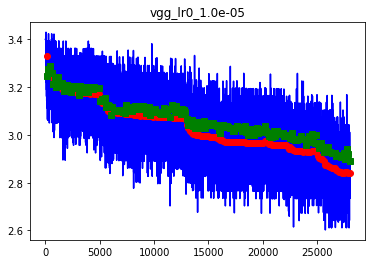

In [ ]:

lossesTR
dlossesTR[test_name]    = lossesTR
dlossesTRAll[test_name] = lossesTRAll
dlossesTE[test_name]    = lossesTE
didxEpoch[test_name]    = idxEpoch
dbestAcc[test_name]     = bestAcc
dnbParam[test_name]     = count_parameters(net)

#for n in ['convnet', 'CNN2']:
for n in [ test_name ]: # ajouter dans cette liste le nom des reseaux que vous tester 
    if n in dlossesTR:
        print ('----------------------------------------------------------------------------')
        print ('----------------------------------------------------------------------------')
        print ('----------------------------------------------------------------------------')
        print (n)
        print ('best accuracy      : '+str(dbestAcc[n].item()))
        print ('best loss on train : '+str(np.min(dlossesTR[n])) + ' idx '+str(np.argmin(dlossesTR[n])))
        print ('best loss on test  : '+str(np.min(dlossesTE[n])) + ' idx '+str(np.argmin(dlossesTE[n])))
        print ('n param            : '+str(dnbParam[n]))

        # evenly sampled time at 200ms intervals
        t = np.arange(0, len(dlossesTRAll[n]))

        plt.plot(t, dlossesTRAll[n], 'b', didxEpoch[n][1:], dlossesTR[n], 'ro', didxEpoch[n][1:], dlossesTE[n], 'gs')
        plt.title(n)
        plt.show()
        

In [ ]:
 for batch_idx, (inputs, targets) in enumerate(testloader):
   break
print(batch_idx)
output = net(inputs.cuda())
print(output[0])
print(targets)

0
tensor([3.3099e-04, 9.4652e-15, 3.1178e-13, 1.4330e-03, 2.8177e-04, 1.3383e-10,
        3.3475e-14, 7.4578e-02, 2.1350e-14, 8.9435e-01, 7.8985e-14, 1.5551e-08,
        6.9655e-08, 2.7980e-15, 6.0735e-15, 1.1134e-15, 2.1719e-15, 8.0750e-05,
        9.7370e-07, 6.4735e-03, 5.0149e-03, 5.8757e-03, 2.6776e-03, 3.1460e-16,
        5.2433e-15, 2.1321e-09, 1.4144e-11, 8.9050e-03, 4.1649e-14, 5.2521e-08],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([ 9, 14,  3,  0,  3, 20, 24, 20, 24, 18, 11, 26,  1, 16,  0, 18,  3,  2,
        20,  3, 26, 20, 23, 21,  5, 17,  0, 29, 21,  7, 28, 24])
